# Outliers

Informally, an **outlier** is a data value that is considered to be far from typical. In some applications, such as detecting earthquakes or cancer, outliers are the cases of real interest. But we will be thinking of them as unwelcome values that might result from equipment failure, confounding effects, mistyping a value, using an extreme value to represent missing data, and so on. In such cases we want to minimize the effect of the outliers on the statistics. 

There are various ways of deciding what "typical" means, and there is no one-size recommendation for all applications. 

## IQR

Let's look at another data set, based on an fMRI experiment.

In [1]:
import pandas as pd
import seaborn as sns

fmri = sns.load_dataset("fmri")
fmri.head()

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970


We want to focus on the *signal* column, splitting according to the *event*.

In [2]:
fmri.groupby("event")["signal"].describe()

,count,mean,std,min,25%,50%,75%,max
event,,,,,,,,
cue,532.0,-0.006669,0.047752,-0.181241,-0.031122,-0.008871,0.015825,0.215735
stim,532.0,0.013748,0.123179,-0.255486,-0.062378,-0.022202,0.058143,0.564985


Here is a box plot of the signal for these groups.

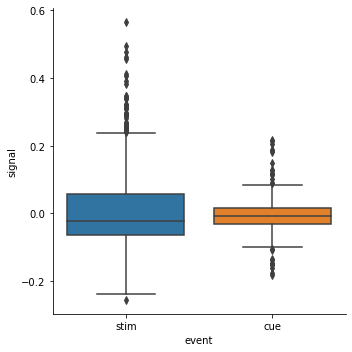

In [3]:
sns.catplot(data=fmri,x="event",y="signal",kind="box")

The dots lying outside the whiskers in the plot may be considered outliers. They are determined by the quartiles. Let $Q_1$ and $Q_3$ be the first and third quartiles (i.e., 25% and 75% percentiles), and let $I=Q_3-Q_1$ be the interquartile range (IQR). Then $x$ is an outlier value if

$$ 
x < Q_1 - 1.5I \text{ or } x > Q_3 + 1.5I.
$$


## Mean and STD

For normal distributions, values more than twice the standard deviation $\sigma$ from the mean might be declared to be outliers; this would exclude 5% of the values, on average. A less aggressive criterion is to allow a distance of $3\sigma$, which excludes only about 0.3% of the values. The IQR criterion above corresponds to about $2.7\sigma$ in the normal case.

The following plot shows the outlier cutoffs for 2000 samples from a normal distribution, using the criteria for 2σ (red), 3σ (blue), and 1.5 IQR (black).

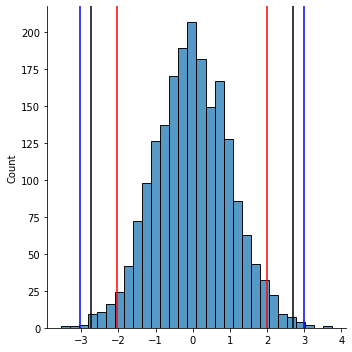

In [4]:
import matplotlib.pyplot as plt
from numpy.random import default_rng
randn = default_rng(1).normal 

x = pd.Series(randn(size=2000))
sns.displot(data=x,bins=30);
m,s = x.mean(),x.std()
plt.axvline(m-2*s,color='r')
plt.axvline(m+2*s,color='r')
plt.axvline(m-3*s,color='b')
plt.axvline(m+3*s,color='b')

q1,q3 = x.quantile([.25,.75])
plt.axvline(q3+1.5*(q3-q1),color='k')
plt.axvline(q1-1.5*(q3-q1),color='k');

For asymmetric distributions, or those with a fat tail, these criteria might show greater differences.

## Removing outliers

It is well known that the mean is more sensitive to outliers than the median is. 

```{prf:example}
The values $1,2,3,4,5$ have a mean and median both equal to 3. If we change the largest value to be a lot larger, say $1,2,3,4,1000$, then the mean changes to 202. But the median is still 3!
```

Let's use IQR to remove outliers from the fmri data set. We do this by creating a Boolean-valued series indicating which rows of the frame represent outliers within their group.

In [5]:
def isoutlier(x):
    Q1,Q3 = x.quantile([.25,.75])
    I = Q3-Q1
    return (x < Q1-1.5*I) |  (x > Q3+1.5*I)

outs = fmri.groupby("event")["signal"].transform(isoutlier)
fmri[outs]["event"].value_counts()

stim    40
cue     26
Name: event, dtype: int64

You can see above that there are 66 outliers. To negate the outlier indicator, we can use `~outs` as a row selector.

In [6]:
cleaned = fmri[~outs]

The median values are barely affected by the omission of the outliers.

In [7]:
print("medians with outliers:")
print(fmri.groupby("event")["signal"].median())
print("\nmedians without outliers:")
print(cleaned.groupby("event")["signal"].median())

medians with outliers:
event
cue    -0.008871
stim   -0.022202
Name: signal, dtype: float64

medians without outliers:
event
cue    -0.009006
stim   -0.028068
Name: signal, dtype: float64


The means show much greater change.

In [8]:
print("means with outliers:")
print(fmri.groupby("event")["signal"].mean())
print("\nmeans without outliers:")
print(cleaned.groupby("event")["signal"].mean())

means with outliers:
event
cue    -0.006669
stim    0.013748
Name: signal, dtype: float64

means without outliers:
event
cue    -0.008243
stim   -0.010245
Name: signal, dtype: float64


For the *stim* case in particular, the mean value changes by almost 200%, including a sign change. (Relative to the standard deviation, it's closer to a 20% change.)  

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_vpsvig7f&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_a1t3d8un" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>